<a href="https://colab.research.google.com/github/100rab-S/Safety-Hat-Detection/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for inference on images and videos

In [ ]:
path = '/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/'

In [ ]:
%cd '$path' 
# or %cd $path

# !git clone --depth 1 https://github.com/tensorflow/models

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2


In [ ]:
# Install the object detection api
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1661033 sha256=2e209962d3f9de943d0c0cd8a2eb9723c20f6ad47613f0b28a5ea7fbd6b979e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-38pcpen7/wheels/f5/49/4c/6338b2f032251ed8f5b1b80b74ca68d7d281b35af74fb12f94
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
import tensorflow as tf
import time
import sys
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

In [ ]:
PATH_TO_SAVED_MODEL="/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/exported-models/my_model_1/saved_model"
print('Loading model...', end='')
# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

Loading model...Done!


In [ ]:
#Loading the label_map
label_path = "/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/annotations/label_map.pbtxt"
category_index=label_map_util.create_category_index_from_labelmap(label_path, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'helmet'},
 2: {'id': 2, 'name': 'head'},
 3: {'id': 3, 'name': 'person'}}

In [37]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def remove_person_class(detections):
    ''' We are not interested in detecting person class. Hence we remove detections of person class.
    '''

    indices_of_person = [i for i, value in enumerate(detections['detection_classes']) if value == 3]
    for key in detections.keys():
        if key == 'num_detections':
            detections[key] = detections[key] - len(indices_of_person)
        else:
            detections[key] = np.delete(detections[key], indices_of_person, axis = 0)

    return detections

def inference(imgs):
    rows = len(imgs)//3
    cols = 3
    figsize = (20, 6*rows)
    fig, axes = plt.subplots(rows, cols, figsize = figsize)
    detected_imgs = []

    for i, (image_path, ax) in enumerate(zip(imgs, axes.ravel())):
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
        detections = detect_fn(input_tensor)
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        detections = remove_person_class(detections)

        label_id_offset = 0
        image_np_with_detections = image_np.copy()


        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.30,
                agnostic_mode=False)
        
        detected_imgs.append(image_np_with_detections)

    for im, ax in zip(detected_imgs, axes.ravel()):
        ax.imshow(im)

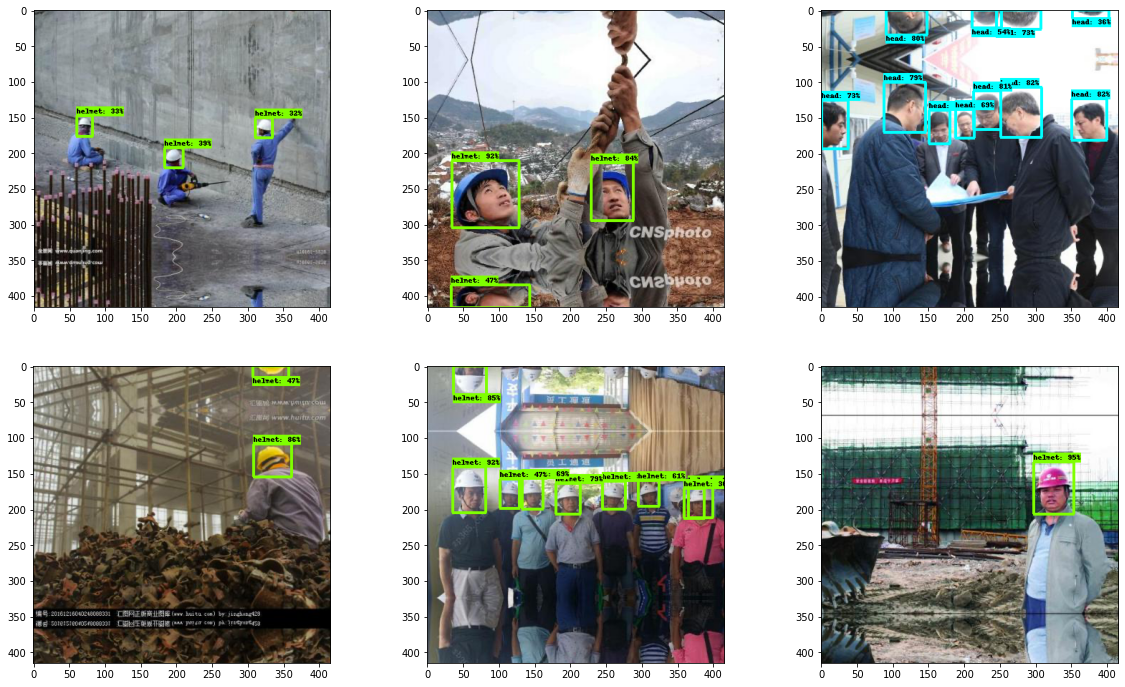

In [38]:
image_indices = random.sample(range(1, 4750), 6)
imgs=[f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[0]}.png',
     f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[1]}.png',
     f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[2]}.png',
     f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[3]}.png',
     f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[4]}.png',
     f'/content/drive/MyDrive/Wobot_Hiring_Test/HardHat_Dataset/images/hard_hat_workers{image_indices[5]}.png']


inference(imgs)

#### Inference on Video

In [31]:
def inference_video(FILE_INPUT, FILE_OUTPUT):
    # Playing video from file
    cap = cv2.VideoCapture(FILE_INPUT)

    # Default resolutions of the frame are obtained.The default resolutions are system dependent.
    # We convert the resolutions from float to integer.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Define the codec and create VideoWriter object.The output is stored in 'output.avi' file.
    # out = cv2.VideoWriter(FILE_OUTPUT, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
    #                       10, (frame_width, frame_height))

    # To create mp4 video
    out = cv2.VideoWriter(FILE_OUTPUT, cv2.VideoWriter_fourcc(*'MP4V'), 15, (frame_width, frame_height))

    sys.path.append("..")

    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret == True:

            input_tensor = tf.convert_to_tensor(np.expand_dims(frame, 0), dtype=tf.uint8)
            detections = detect_fn(input_tensor)
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                        for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
            detections = remove_person_class(detections)
            # print(detections)
            label_id_offset = 0
            image_np_with_detections = frame.copy()

            viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                (detections['detection_classes'] + label_id_offset).astype(int),
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.30,
                agnostic_mode=False)

            # cv2_imshow(image_np_with_detections)
            out.write(image_np_with_detections)

        else:
            break

        # When everything done, release the video capture and video write objects
    cap.release()
    out.release()
    print('Video created!')

# Closes all the frames
# cv2.destroyAllWindows()

In [32]:
# FILE_OUTPUT = '/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/out_video.avi'

# For mp4 file
FILE_OUTPUT = '/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/out_video.mp4'

# Checks and deletes the output file
# You cant have a existing file or it will through an error
if os.path.isfile(FILE_OUTPUT):
    os.remove(FILE_OUTPUT)

# FILE_INPUT = '/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/hello.mp4'
FILE_INPUT = '/content/drive/MyDrive/Wobot_Hiring_Test/TensorFlow2/workspace/training/Top 10 Safety Vest For Construction For Men And Women (360p_24fps_H264-128kbit_AAC).mp4'

inference_video(FILE_INPUT, FILE_OUTPUT)

Video created!
